In [5]:
from toggle_equations import toggle_rhs
from attractor_stats import *
from steady_states import *
from sim_funcs import *
from plotting_funcs import *

from collections import OrderedDict,Counter
#from networkx.drawing.nx_agraph import to_agraph
from matplotlib import rc

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
#import networkx as nx
import copy

%matplotlib inline
sns.set(style='white', context='notebook', 
        palette='muted', rc={'axes.labelsize': 16})

# Toggle switch

## Architecture of the *Cis*- regulatory function:


<p>
<img src="images/toggle_schematic.png" width="500"/>    
</p>



**Hill-equation**:

$$ \frac{dx}{dt} = (\alpha_{1} + \frac{max_{1}x^n}{a^n + x^n})(\frac{b^n}{b^n + y^n}) - \lambda_{1}x_{1} $$

$$ \frac{dy}{dt} = (\alpha_{2} + \frac{max_{2}y^n}{c^n + y^n})(\frac{d^n}{d^n + x^n}) - \lambda_{2}x_{2} $$

where:
- `x` and `y` are the concentrations of the 2 proteins X and Y.
- $\alpha_{1}$ and $\alpha_{2}$ are the rates of production of gene X/Y, in absence of activation by X/Y.
- `n` is the Hill coefficient.
- `a` and `c` are the concentrations for the half-maximal activation by genes X/Y on genes X/Y. The inverses, $\frac{1}{a}$   and $\frac{1}{c}$ represents the efficiency of the activator in other equivalent formulations (see Goutsias and Kim, 2004) 
- `b` and `d` are the concentrations for the half-maximal repression by genes X/Y on genes Y/X. The inverses, $\frac{1}{b}$
and $\frac{1}{d}$ represents the efficiency of the repressor in other equivalent formulations.
- $max_{1}$ and $max_{2}$ are the maximum rates of protein production by activators X / Y. To see this, 
  take $\displaystyle\lim_{a \to 0} \frac{max_{1}x^n}{a^n + x^n}$

Equation is modified from Verd et al., (2014) and Jaeger et al., (2012), with
the exact form seen in Laslo et al.,(2006) - see supplementary equation S1.
In the Verd and Jaeger formulation, the maximum rate of protein production 
set by the activator is implicitly set to 1 - this has been adjusted in the stochastic simulation
to convert concentrations (continuous) to molecule counts (discrete).

**General assumptions in Michaelis-like formulations**
1.  Extreme cooperativity. (Hill, 1985, pg 65)
2.  AND regulatory logic. 
3.  Polymerase is present in excess.
4.  Activator and repressor act at independent sites.


In the Laslo paper:
"The term $e_{0}$ is included to avoid extending the network to include activators for the primary cell fate determinants". In other words, we take $\alpha_{1}$ and $\alpha_{2}$ to encapsulate the net effect of all other regulators on the rate of production of the principal cell fate determinants - `x` and `y`. 


In [8]:
# Parameters in deterministic term
alpha1 = 0.25
alpha2 = 0.25
a = c = 0.6
b = 0.4
d = 0.4
max1 = 1
max2 = 1
lambda1 = 1.25
lambda2 = 1.25
path_colors = [[] for i in range(len(myPara))]



# Bifurcation diagram

## Parameter range for alpha

In [51]:
num = 10000
myList = list(zip(np.linspace(0,1,num), [0.3]*num)) 
myPara_bif = list(map(list, myList))


## Steady states and classifying stability

In [52]:
x_coordinate_ss, y_coordinate_ss = steady_states (alpha1, alpha2, a, c, b, d, lambda1, lambda2, myPara_bif)
stable_steady_states, unstable_steady_states = stability (alpha1, alpha2, a, c, b, d, lambda1, lambda2, x_coordinate_ss, y_coordinate_ss)
grouped_stable_ss, grouped_unstable_ss = group_steady_states(stable_steady_states, unstable_steady_states, myPara_bif)

/home/porcupine/miniconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/home/porcupine/miniconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


## Plot - Bifurcation diagram

Text(0, 0.5, '$\\ x$')

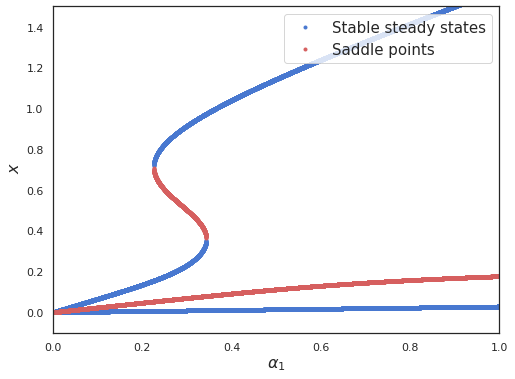

In [53]:
fig, axis = plt.subplots(1,1, figsize = (8,6))

x_vals_stable = np.array(stable_steady_states)[:,0,0]
x_vals_unstable = np.array(unstable_steady_states)[:,0,0]
genex_vals_stable = np.array(stable_steady_states)[:,0,2]
genex_vals_unstable = np.array(unstable_steady_states)[:,0,2]

axis.plot(x_vals_stable,genex_vals_stable, '.b',  label='Stable steady states')
axis.plot(x_vals_unstable,genex_vals_unstable, '.r', label = 'Saddle points')

plt.axis([0, 1, -0.1, 1.5])
plt.legend(loc = "upper right", prop={'size': 15})
plt.xlabel(r'$\alpha_{1}$');
plt.ylabel('$\ x$')

#plt.savefig('images/02_test_bifurcation_ext_act_asymmetric.png', bbox_inches='tight')          

<p>
<img src="images/02_bifurcation_ext_act_asymmetric.png" width="500"/>    
</p>


# Deterministic phase portraits

## Parameters

In [98]:
myPara = [[0.3, 0.8], [0.3, 0.3], [0.8, 0.3]] # Values of parameters that I am changing.

ss_colors = ['#38b6ff', '#ff9400', '#99dd44'] # Since we have a maximum of 3 attractors (stable ss)
ss_unstable_colors = ['#ed1c24', '#fe6dbc', '#fca085'] 
path_colors = [[] for i in range(len(myPara))]

#For plotting
grid_range = np.linspace(0,1.5, num =15)
dt = 0.1
num_paths = len(grid_range)**2
num_timesteps = 1000
x_init = 0.6
y_init = 0.6

## Steady states and classifying stability

In [80]:
x_coordinate_ss, y_coordinate_ss = steady_states (alpha1, alpha2, a, c, b, d, lambda1, lambda2, myPara)
stable_steady_states, unstable_steady_states = stability (alpha1, alpha2, a, c, b, d, lambda1, lambda2,x_coordinate_ss, y_coordinate_ss)
grouped_stable_ss, grouped_unstable_ss = group_steady_states(stable_steady_states, unstable_steady_states, myPara)

/home/porcupine/miniconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


In [84]:
grouped_unstable_ss

array([array([[[0.3       , 0.8       , 0.53008919],
        [0.3       , 0.8       , 0.15762639]]]),
       array([[[0.3       , 0.3       , 0.06960738],
        [0.3       , 0.3       , 0.50043901]],

       [[0.3       , 0.3       , 0.50043901],
        [0.3       , 0.3       , 0.06960738]]]),
       array([[[0.8       , 0.3       , 0.15762639],
        [0.8       , 0.3       , 0.53008919]]])], dtype=object)

## Simulating paths

In [100]:
""" Line21: When changing the identity of the parameters, remember to change the argument in the toggle_rhs function """

num_para = len(myPara)
paths = np.zeros((num_para, num_paths, num_timesteps, 2))
tol = 10**(-2)

for h in range(num_para):
    path_counter = 0
    x_ss_stable = grouped_stable_ss[h][:,0][:,2]
    #print(x_ss_stable)
    y_ss_stable = grouped_stable_ss[h][:,1][:,2]
    #print(y_ss_stable)
    for i in grid_range:
        for j in grid_range:
            path_counter += 1
            xp = i
            yp = j
            paths[h, path_counter-1, 0, 0] = xp
            paths[h, path_counter-1, 0, 1] = yp
            for k in range(1, num_timesteps):
                current_coordinate = [xp,yp]
                [dxdt,dydt] = toggle_rhs(current_coordinate, myPara[h][0], myPara[h][1], a, c, b, d, lambda1, lambda2)
                dx = dxdt * dt
                dy = dydt * dt
                xp += dx
                yp += dy  
                paths[h, path_counter-1, k, 0] = xp
                paths[h, path_counter-1, k, 1] = yp
            for ss_index in range(len(x_ss_stable)):
                ss_coordinates = [x_ss_stable[ss_index], y_ss_stable[ss_index]]
                if np.sqrt((xp-ss_coordinates[0])**2 + (yp-ss_coordinates[1])**2) < tol:
                    path_colors[h].append(ss_colors[ss_index]) 
                    break
                elif ss_index == (len(x_ss_stable) - 1) :
                    unstable_index = np.array([x for x in range(len(grouped_unstable_ss)) if grouped_unstable_ss[x].any() and myPara[h][0] == grouped_unstable_ss[x][:,0][:,0][0]])
                    if unstable_index.size>0: 
                        x_ss_unstable = grouped_unstable_ss[unstable_index[0]][:,0][:,2]
                        y_ss_unstable = grouped_unstable_ss[unstable_index[0]][:,1][:,2]
                        for ss_index in range(len(x_ss_unstable)):
                            ss_coordinates = [x_ss_unstable[ss_index], y_ss_unstable[ss_index]]
                            if np.sqrt((xp-ss_coordinates[0])**2 + (yp-ss_coordinates[1])**2) < tol:
                                path_colors[h].append(ss_unstable_colors[ss_index]) 
                                break
                    else:
                        break 


## Plot - Phase portraits

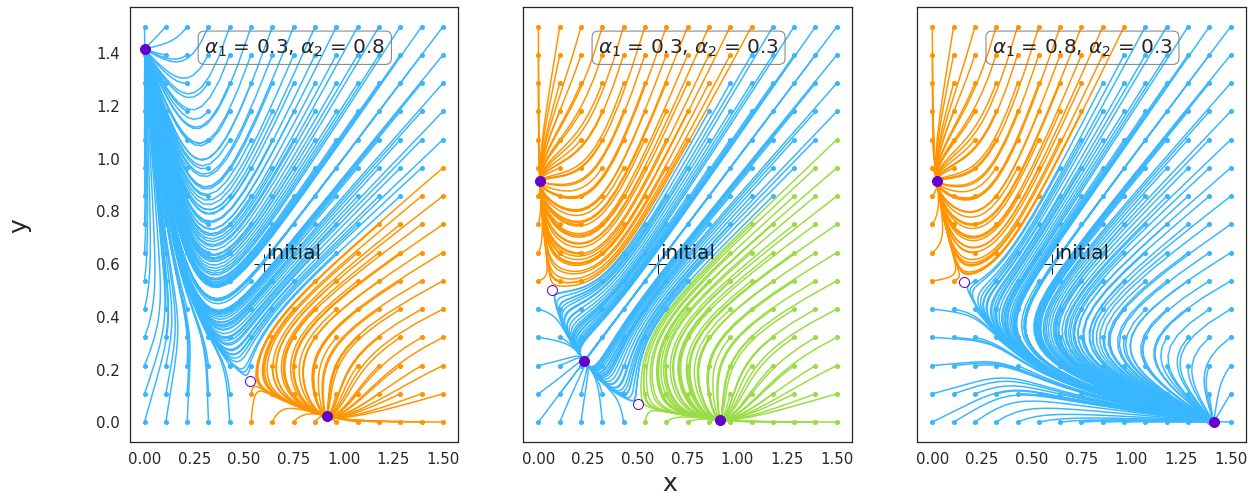

In [115]:
plt.rcParams.update({'font.size':20})

fig , axes = plt.subplots(1,3, figsize = (20,8), sharex=True, sharey=True)
ax = axes.flatten()
fig.text(0.5, 0.04, 'x', ha ='center', fontsize = 25)
fig.text(0.04, 0.5, 'y', va='center', rotation='vertical', fontsize = 25)

for i in range(num_para):
    ax[i].annotate('{} = {}, {} = {}'.format(r'$\alpha_{1}$',myPara[i][0], r'$\alpha_{2}$', myPara[i][1]), xy=(0.3, 1.4), xycoords='data', bbox=dict(boxstyle="round", fc="none", ec="gray"), size = 20)
    ax[i].annotate('initial', xy=(x_init, y_init),  xycoords='data', xytext=(x_init + 0.01, y_init + 0.02), color = 'k')
    ax[i].plot(x_init, y_init, '+', color = 'k', markersize= 20 )
    ax[i].tick_params(axis='both', which='major', labelsize=15)
    
    for j in range(num_paths):
        ax[i].plot(paths[i,j,:,0], paths[i,j,:,1], color=path_colors[i][j])
        ax[i].plot(paths[i,j,0,0], paths[i,j,0,1], marker = '.', color=path_colors[i][j],  markersize=8)
       
    ax[i].plot(grouped_stable_ss[i][:,0][:,2], grouped_stable_ss[i][:,1][:,2], '.', color = "#6600cc",  markersize= 20)
    unstable_index = np.array([x for x in range(len(grouped_unstable_ss)) if grouped_unstable_ss[x].any() and (myPara[i][1] == grouped_unstable_ss[x][:,0][:,1][0] and myPara[i][0] == grouped_unstable_ss[x][:,0][:,0][0])])
    if unstable_index.size>0: 
        x_ss_unstable = grouped_unstable_ss[unstable_index[0]][:,0][:,2]
        y_ss_unstable = grouped_unstable_ss[unstable_index[0]][:,1][:,2]
        for ss_index in range(len(x_ss_unstable)):
            ax[i].plot(x_ss_unstable[ss_index], y_ss_unstable[ss_index], '.', color = "#6600cc", mfc='none', markersize= 20 )

#fig.savefig('plots_stochastic/1_det_phasePortraits_ext_act_asymmetry.png', bbox_inches='tight')
